# Facies Interpretation via Machine Learning

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle




## Import the raw data

In [4]:
xls = pd.ExcelFile('MultiWell2.xls')
print(xls.sheet_names)
data=[]

df = pd.concat(pd.read_excel('MultiWell2.xls', sheet_name=None), ignore_index=True)
    
df=df.loc[(df["Log102"] > 7)]




['159F140', '159F1B2']


15/9-F-14
             DT       DTS          GR         RHOB   wellname
18409  0.000242  0.000516   61.444302  2642.199951  15/9-F-14
18410  0.000241  0.000511   68.449799  2676.600098  15/9-F-14
18411  0.000237  0.000507   87.919098  2659.100098  15/9-F-14
18412  0.000242  0.000566  123.958801  2619.199951  15/9-F-14
18413  0.000263  0.000566  167.533905  2549.000000  15/9-F-14


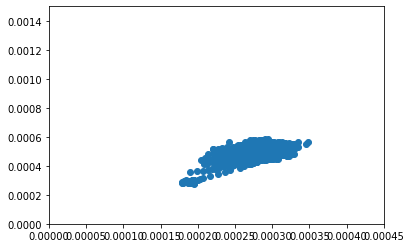

15/9-F-1 B
             DT       DTS          GR         RHOB    wellname
53991  0.000318  0.000592  128.987305  2470.500000  15/9-F-1 B
53992  0.000316  0.000591  128.195999  2479.399902  15/9-F-1 B
53993  0.000314  0.000591  129.119400  2489.800049  15/9-F-1 B
53994  0.000313  0.000592  128.473297  2497.899902  15/9-F-1 B
53995  0.000313  0.000593  127.366898  2501.600098  15/9-F-1 B


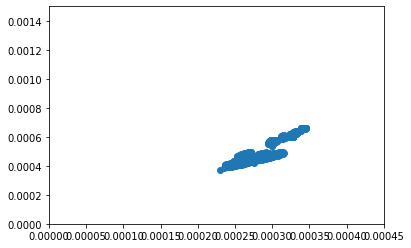

In [5]:
    

#print(df.head())

labels, uniques =pd.factorize(df['wellname'])

#print(labels)

#df['WellID']=labels

subset=df[['DT','DTS','GR','RHOB','wellname']]
subset=subset.dropna()
#print(subset.describe())

for a in uniques:
  print(a)
  new=subset.loc[(subset["wellname"] == a)]
  print(new.head())
  fig, ax = plt.subplots()
  plt.scatter(x='DT', y='DTS', data=new)
  ax.set_xlim(0,0.00045)
  ax.set_ylim(0,0.0015)
  plt.show()




In [6]:
#Calc VShale and a Facies
subset['Vsh']=subset['GR']-10/85-10


def faciesfromvsh(vsh):
    facies=""
    if vsh>50:
        facies="Shale"
    if vsh<30:
        facies="Sand"
    if vsh>30 and vsh<50:
        facies="Shaley Sand"
    return facies

subset['Facies']=subset['Vsh'].apply(faciesfromvsh)

print(subset[['Vsh','Facies','wellname']].head())


              Vsh Facies   wellname
18409   51.326655  Shale  15/9-F-14
18410   58.332152  Shale  15/9-F-14
18411   77.801451  Shale  15/9-F-14
18412  113.841154  Shale  15/9-F-14
18413  157.416258  Shale  15/9-F-14


(0.0002, 0.0008)

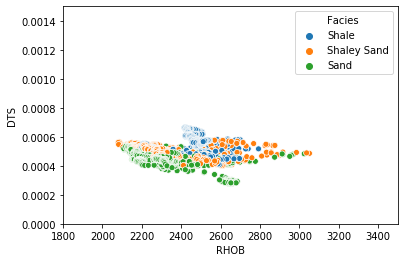

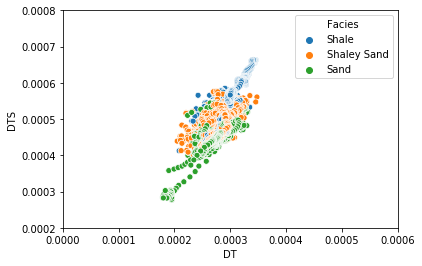

In [7]:
#Plot the data using seabron
fig, ax = plt.subplots()
g = sns.scatterplot(x='RHOB', y='DTS', data=subset, hue='Facies')
ax.set_xlim(1800,3500)
ax.set_ylim(0,0.0015)

fig, ax = plt.subplots()
g = sns.scatterplot(x='DT', y='DTS', data=subset, hue='Facies')
ax.set_xlim(0,0.0006)
ax.set_ylim(0.0002,0.0008)

## Define Machine Learning model

For generating a machine learning model we must first split the data into a set of Features (those properties used to train) and Targets (those features we want to predict)

It is also best practical to hold some data back for validation

Our model type is a "random forest classifier" but could be SVM or other types.

<img src='./rfc.png' style="width:600px;height:400px;">

In [107]:
features=['RHOB','DT','DTS','GR']
targets=['Facies']


train, test = train_test_split(subset, test_size=0.2)

clf = RandomForestClassifier(bootstrap=True, max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=0, verbose=1, warm_start=False)

Xtrain = train[features]
Ytrain = train[targets]
clf.fit(Xtrain, Ytrain)
clf.score(Xtrain, Ytrain)

Xtest = test[features]
Ytest = test[targets]
clf.score(Xtest, Ytest)

C:\Users\brucech\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


0.998003992015968

## Feature importance

In [108]:


feat_labels=Xtrain.columns

importances=clf.feature_importances_
#print(importances)

indices=np.argsort(importances)[::-1]

for f in range(Xtrain.shape[1]):
    print(feat_labels[indices[f]],importances[indices[f]])

GR 0.7891328572891178
DTS 0.11515262094575653
RHOB 0.08274548398397825
DT 0.012969037781147377


In [109]:
from sklearn.metrics import classification_report


print(classification_report(Ytest, clf.predict(Xtest)))

              precision    recall  f1-score   support

        Sand       1.00      1.00      1.00       465
       Shale       0.99      0.99      0.99       122
 Shaley Sand       1.00      1.00      1.00       415

    accuracy                           1.00      1002
   macro avg       1.00      1.00      1.00      1002
weighted avg       1.00      1.00      1.00      1002



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


# Save the Pickle

We then save the state of the model to bring back to petrel to predict new data


In [110]:

# Save to file in the current working directory
pkl_filename = ".//pickle_model_volve.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(clf, file)



In [3]:

#from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython import display

#from graphviz import Digraph

#print(features,targets)


#str_tree=export_graphviz(clf.estimators_[5],feature_names=features,class_names = subset.Facies.unique(),filled=True,rounded=True,out_file='tree.dot')


#!dot -Tpng tree.dot -o tree.png -Gdpi=600

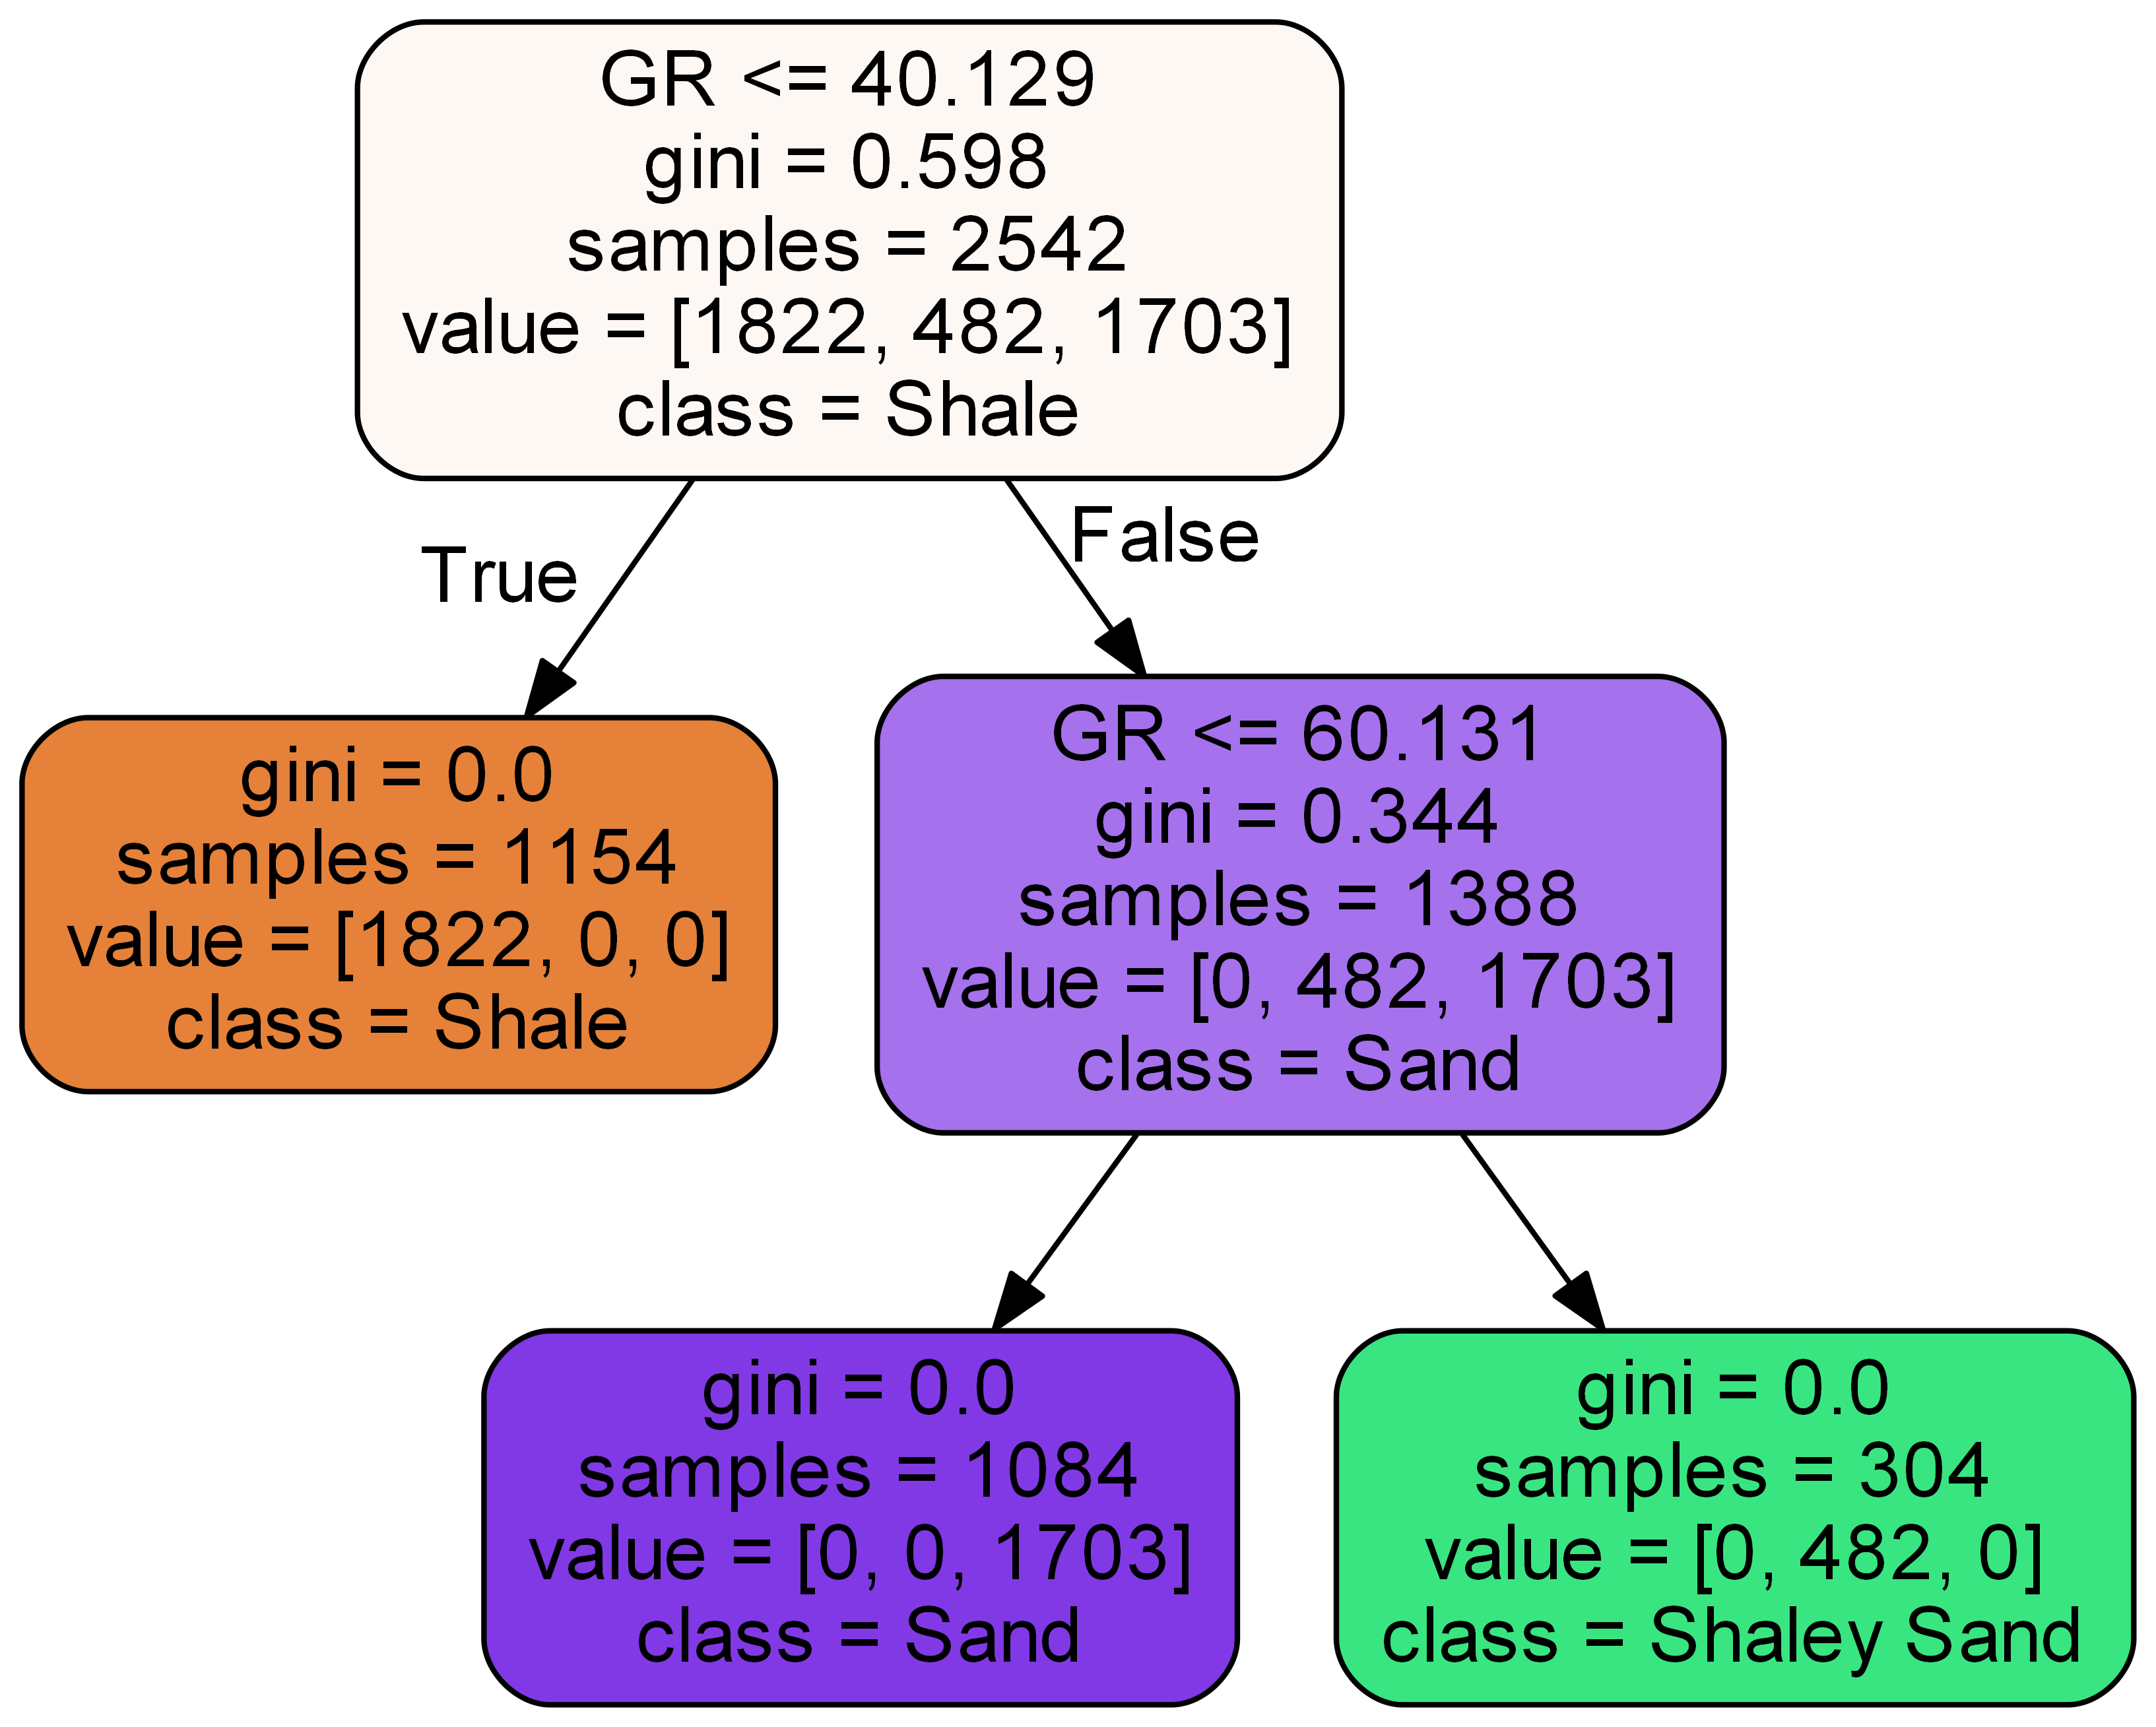

In [4]:
Image(filename = 'tree.png')